# Ingesting Daily Covid Data

Making Preliminary Visualizations on COVID cases using the COVID Tracking Project's Data

Importing Requirements

In [17]:
import pandas as pd 
import requests 
import seaborn as sns;sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
%matplotlib inline
from beakerx.object import beakerx
beakerx.pandas_display_table()

pd.options.display.max_rows = 999
import io
from datetime import datetime

from utils import *
hide_toggle()

Spark Setup

In [3]:
import pyspark
from pyspark import SQLContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer

spark = SparkSession.builder.getOrCreate()
sqlCtx = spark._wrapped

hide_toggle()

Splice Setup

In [5]:
from splicemachine.spark.context import PySpliceContext
from splicemachine.ml.management import MLManager

splice=PySpliceContext(spark)
manager = MLManager(splice)

hide_toggle()

Tracking Model Metadata on MLFlow Server @ http://splicedb-mlflow-0.splicedb-mlflow.mldemo.svc.cluster.local:5001


Investigating Data In Splice Table Using `SQL` 

In [19]:
us_daily = pd.DataFrame.from_dict(requests.get('https://covidtracking.com/api/us/daily').json())
states_daily = pd.DataFrame.from_dict(requests.get('https://covidtracking.com/api/states/daily').json())
len(states_daily)

1541

In [15]:
%%sql 
SELECT * FROM COVID.RAW_DATA ORDER BY DATE DESC

Importing Data Using Native Spark Data Source

In [108]:
from splicemachine.spark.context import PySpliceContext
from splicemachine.ml.management import MLManager

splice=PySpliceContext(spark)

us_daily = splice.df("SELECT * FROM COVID.RAW_DATA").toPandas()
us_daily['datetime'] = us_daily.DATE.astype(str).apply(lambda x: datetime.strptime(x,'%Y%m%d'))


<class 'pyspark.sql.dataframe.DataFrame'>


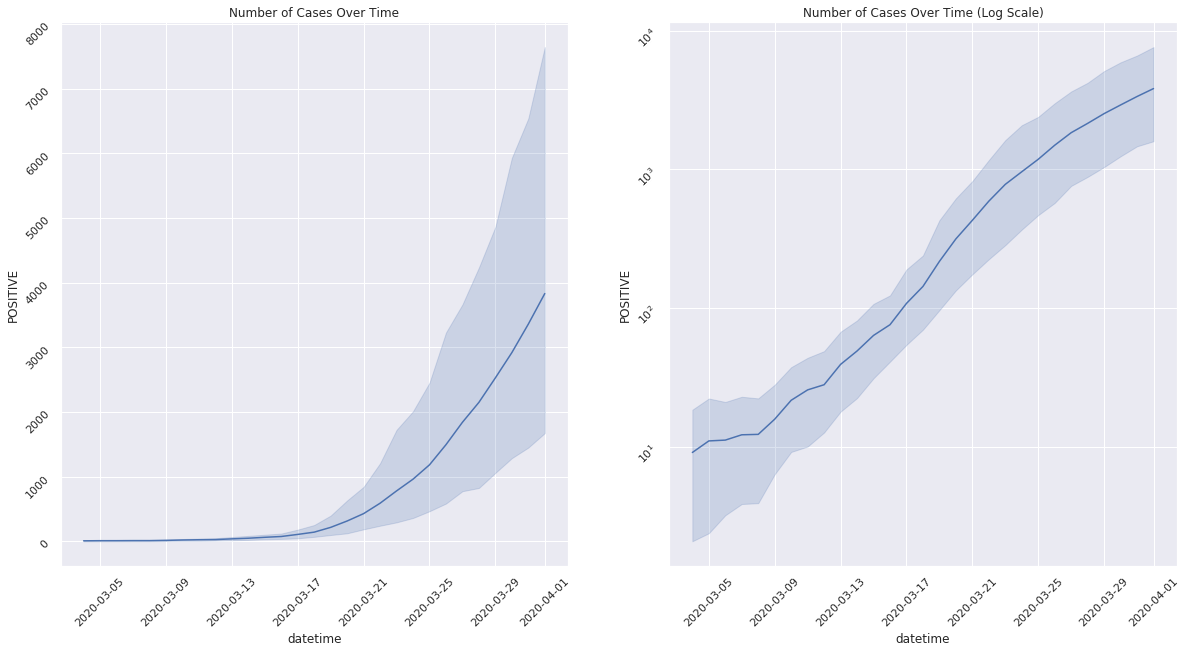

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

axes[0] =sns.lineplot(x = 'datetime', y = 'POSITIVE', data = us_daily, ax = axes[0])
axes[0].set_title("Number of Cases Over Time")
axes[0].tick_params(labelrotation=45)
axes[1] =sns.lineplot(x = 'datetime', y = 'POSITIVE', data = us_daily, ax = axes[1])
axes[1].set_title("Number of Cases Over Time (Log Scale)")
axes[1].tick_params(labelrotation=45)
axes[1].set(yscale="log")

hide_toggle()

Building Basic Linear Regression of The Number of Cases over time

In [105]:
from matplotlib import pyplot, dates

total_positives = total_positives = us_daily.groupby('DATE').apply(lambda x: sum(x['POSITIVE'])).rename('total_positives')
total_positives = total_positives.reset_index()
total_positives['datetime'] = total_positives.DATE.astype(str).apply(lambda x: datetime.strptime(x,'%Y%m%d'))
total_positives['datenum'] = dates.datestr2num(total_positives['datetime'].apply(str).values)
total_positives['log_pos'] = np.log(total_positives['total_positives'])
hide_toggle()

In [103]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
results = smf.ols('log_pos ~ index', data=total_positives.reset_index()).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                log_pos   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3365.
Date:                Thu, 02 Apr 2020   Prob (F-statistic):           7.01e-30
Time:                        21:04:38   Log-Likelihood:                 4.2424
No. Observations:                  29   AIC:                            -4.485
Df Residuals:                      27   BIC:                            -1.750
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0092      0.078     63.875      0.0

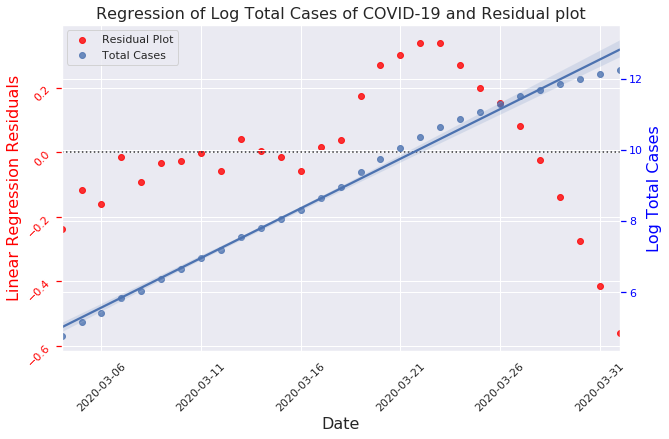

In [109]:
@pyplot.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return dates.num2date(x).strftime('%Y-%m-%d')


#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
#bar plot creation
ax1.set_title('Regression of Log Total Cases of COVID-19 and Residual plot', fontsize=16)
ax1 = sns.residplot(x = 'datenum', y = 'log_pos', data=total_positives, color = 'red',label = 'Residual Plot')
ax1.xaxis.set_major_formatter(fake_dates)
ax1.set_xlim(left = min(total_positives['datenum']), right = max(total_positives['datenum']))
# legible labels
ax1.tick_params(labelrotation=45)

#specify we want to share the same x-axis
ax2 = ax1.twinx()
#line plot creation
ax2 = seaborn.regplot('datenum', 'log_pos', data=total_positives,label = 'Total Cases')

# ax2.get_legend().remove()
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax2.transAxes)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Linear Regression Residuals', fontsize=16)
_ = ax2.set_ylabel('Log Total Cases', fontsize=16)

ax1.tick_params(axis='y', colors='red')
ax1.yaxis.label.set_color('red')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
hide_toggle()


Of Note: The residuals of the last week are negative indicating that the exponential growth trend is slowing relative to its previous rate

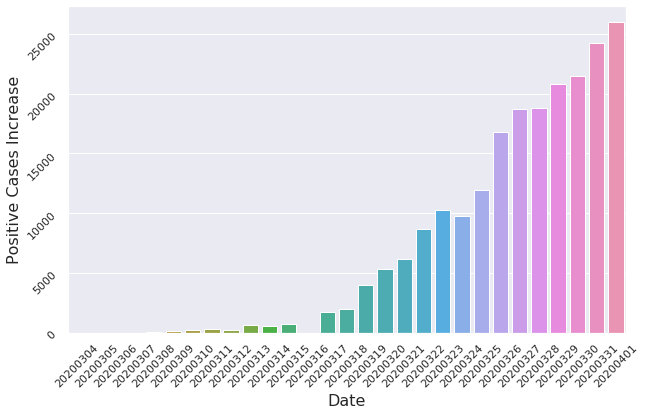

In [94]:
pos_increase = total_positives = us_daily.groupby('DATE').apply(lambda x: sum(x['POSITIVEINCREASE'])).rename('total_positive_increase').reset_index()
pos_increase['datestr'] = pos_increase.DATE.astype(str)
pos_increase['datenum'] = dates.datestr2num(pos_increase['datestr'].values)

fig, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(x = 'datestr', y = 'total_positive_increase', data = pos_increase, ax = ax)
# ax.xaxis.set_major_formatter(fake_dates)
ax.tick_params(labelrotation=45)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Positive Cases Increase', fontsize=16)

hide_toggle()